<ipython-input-22-76a91543f935>:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(sol.t))


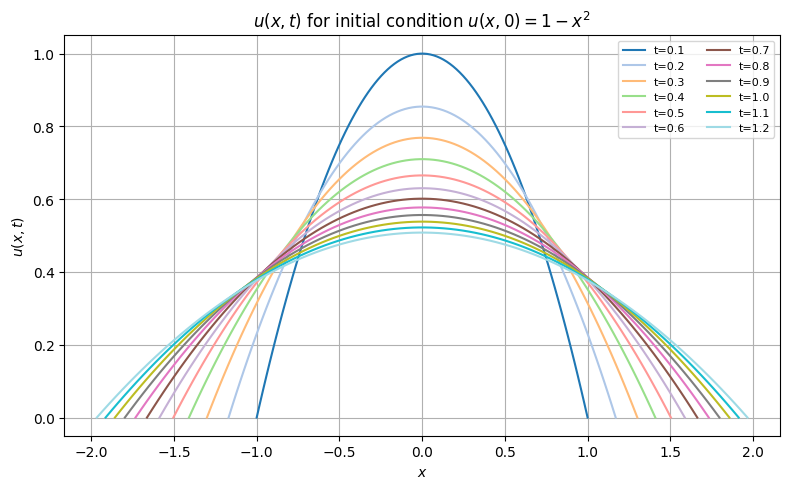

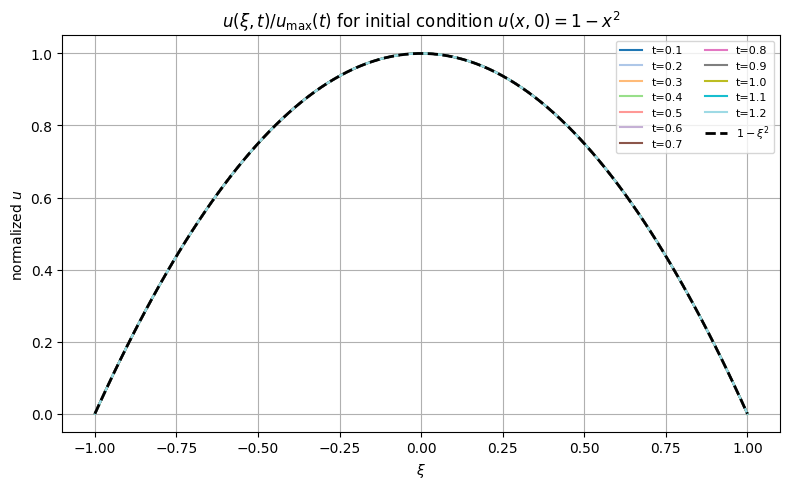

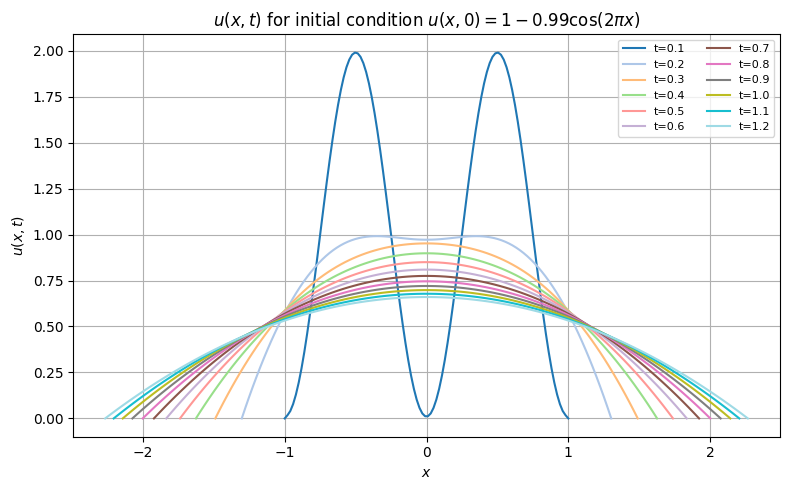

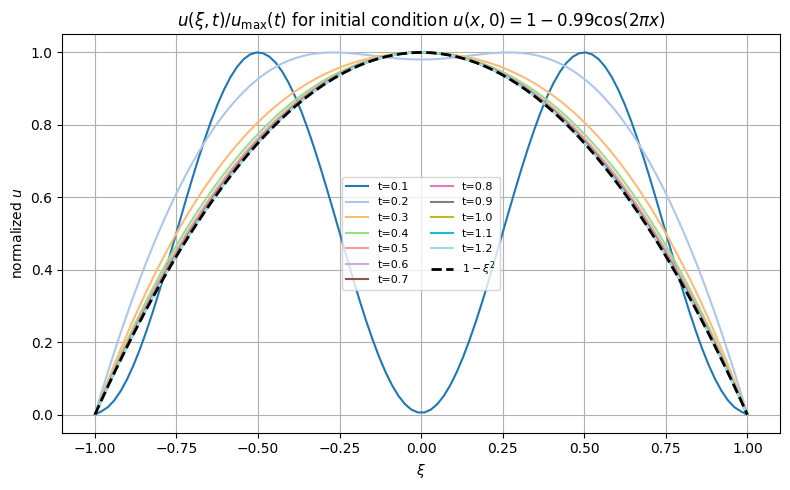

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.cm as cm


n = 100
xi = np.linspace(-1, 1, n+2)
h = xi[1] - xi[0]
t_eval = np.linspace(0.1, 1.2, 12)

def initial_condition_1(x):
    return np.where(np.abs(x) < 1, 1 - x**2, 0)

def initial_condition_2(x):
    return np.where(np.abs(x) < 1, 1 - 0.99 * np.cos(2 * np.pi * x), 0)

def pack(u, xL, xR):
    return np.concatenate([u, [xL, xR]])

def unpack(y):
    u = y[:-2]
    xL, xR = y[-2], y[-1]
    return u, xL, xR

def rhs(t, y):
    u, xL, xR = unpack(y)
    x0 = 0.5 * (xL + xR)
    xf = 0.5 * (xR - xL)

    dudt = np.zeros_like(u)

    du = np.zeros_like(u)
    du[1:-1] = (u[2:] - u[:-2]) / (2*h)
    du[0] = (4*u[1] - u[2]) / (2*h)
    du[-1] = (-4*u[-2] + u[-3]) / (2*h)

    ddu = np.zeros_like(u)
    ddu[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / h**2

    adv = -0.5 * ((1 + xi) * du[-1] + (1 - xi) * du[0])

    dudt[1:-1] = (1 / xf**2) * (adv[1:-1] * du[1:-1] + u[1:-1] * ddu[1:-1] + du[1:-1]**2)

    dxL_dt = -du[0] / xf
    dxR_dt = -du[-1] / xf

    return pack(dudt, dxL_dt, dxR_dt)

def solve_and_plot(initial_condition, title_suffix):
    u0 = initial_condition(xi)
    u0[0] = u0[-1] = 0
    xL0, xR0 = -1.0, 1.0
    y0 = pack(u0, xL0, xR0)

    sol = solve_ivp(rhs, [0.1, 1.2], y0, t_eval=t_eval, method='BDF')

    cmap = cm.get_cmap('tab20', len(sol.t))
    colors = [cmap(i) for i in range(len(sol.t))]

    plt.figure(figsize=(8, 5))
    for k, t in enumerate(sol.t):
        u_k, xL_k, xR_k = unpack(sol.y[:, k])
        x_k = xL_k + 0.5 * (xR_k - xL_k) * (xi + 1)
        plt.plot(x_k, u_k, label=f't={t:.1f}', color=colors[k])
    plt.title(f'$u(x,t)$ for {title_suffix}')
    plt.xlabel('$x$')
    plt.ylabel('$u(x,t)$')
    plt.legend(ncol=2, fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    for k, t in enumerate(sol.t):
        u_k, _, _ = unpack(sol.y[:, k])
        u_max = np.max(u_k)
        u_norm = u_k / u_max if u_max != 0 else u_k
        plt.plot(xi, u_norm, label=f't={t:.1f}', color=colors[k])
    plt.plot(xi, 1 - xi**2, 'k--', linewidth=2, label='$1 - \\xi^2$')
    plt.title(f'$u(\\xi,t)/u_{{\\max}}(t)$ for {title_suffix}')
    plt.xlabel('$\\xi$')
    plt.ylabel('normalized $u$')
    plt.legend(ncol=2, fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()


solve_and_plot(initial_condition_1, 'initial condition $u(x,0) = 1 - x^2$')
solve_and_plot(initial_condition_2, 'initial condition $u(x,0) = 1 - 0.99 \\cos(2\\pi x)$')


In [18]:
#content of distmesh.py
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import Delaunay
from scipy import sparse

# input arguments
#      fd:        Distance function d(x,y)
#      fh:        Scaled edge length function h(x,y)
#      h0:        Initial edge length
#      bbox:      Bounding box [xmin,ymin; xmax,ymax] MASHA: [xmin,xmax,ymin,ymax]
#      pfix:      Fixed node positions (NFIXx2)

# output
#      pts:         Node positions (Nx2)
#      tri:         Triangle indices (NTx3)

def huniform(p):
    m,n = np.shape(p)
    return np.ones((m,1))

def ddiff(d1,d2):
    return np.maximum(d1,-d2)

def dcircle(p,xc,yc,r):
    return np.sqrt((p[:,0]-xc)**2+(p[:,1]-yc)**2)-r

def dellipse(p,xc,yc,rx,ry):
    return np.sqrt(((p[:,0]-xc)**2)/rx**2+((p[:,1]-yc)**2)/ry**2)-1

def drectangle(p,x1,x2,y1,y2):
    d1 = np.minimum(-y1+p[:,1],y2-p[:,1])
    d2 = np.minimum(d1,-x1+p[:,0])
    return -np.minimum(d2,x2-p[:,0])

def dintersect(d1,d2):
    return np.maximum(d1,d2)

def dunion(d1,d2):
    return np.minimum(d1,d2)

def dline(p,x1,y1,x2,y2):
    # signed distance from point p to line through (x1,y1) and  (x2,y2)
    # normal vector to the line
    nx = y1-y2
    ny = x2-x1
    nn = np.sqrt(nx*nx+ny*ny)
    # return (p-(x1,x2))*n/||n||
    return -((p[:,0]-x1)*nx+(p[:,1]-y1)*ny)/nn

def dtriangle(p,x1,y1,x2,y2,x3,y3):
    return np.maximum(dline(p,x1,y1,x2,y2),np.maximum(dline(p,x2,y2,x3,y3),dline(p,x3,y3,x1,y1)))

def triarea(pts,tri):
    # calculates areas of mesh triangles
    # p = [x_vec,y_vec]
    # tri = [ind0,ind1,ind2]
    d12 = pts[tri[:,1],:]-pts[tri[:,0],:]
    d13 = pts[tri[:,2],:]-pts[tri[:,0],:]
    A = d12[:,0]*d13[:,1]-d12[:,1]*d13[:,0]
    return A

def fixmesh(pts,tri):
    TOL = 1.0e-10
    # remove repeated nodes
    pts,idx = np.unique(pts,axis = 0,return_inverse = True)
    tri = np.reshape(idx[tri],np.shape(tri))

    # compute areas of mesh triangles
    A = triarea(pts,tri)
    idx_tri_reorder = np.argwhere(A < 0)
    Nidx = np.size(idx_tri_reorder)
    idx_tri_reorder = np.reshape(idx_tri_reorder,(Nidx,))
    if np.any(idx_tri_reorder):
        # reorder triangles with negative area
        tmp = tri[idx_tri_reorder,0]
        tri[idx_tri_reorder,0] = tri[idx_tri_reorder,1]
        tri[idx_tri_reorder,1] = tmp
    # remove triangles with too small area
    idx_keep = np.argwhere(np.absolute(A) > TOL*np.linalg.norm(A,np.inf))
    Nidx = np.size(idx_keep)
    idx_keep = np.reshape(idx_keep,(Nidx,))
    tri = tri[idx_keep,:]
    # remove unused nodes
    Ntri,m = np.shape(tri)
    t_col = np.reshape(tri,(Ntri*m,))
    idx,iidx = np.unique(t_col,return_inverse = True)
    pts = pts[idx,:]
    tri = np.reshape(iidx,(Ntri,m))
    return pts,tri

def distmesh2D(fd,fh,h0,bbox,pfix):
    # parameters
    dptol=.001
    ttol=.1
    Fscale=1.2
    deltat=.2
    geps=.001*h0
    deps=math.sqrt(np.finfo(float).eps)*h0
    MAXcount = 5000
    densityctrlfreq=30
    jshow = 200  # display progress every jshow iterations

    # define the initial set of points by
    # making a mesh of equilateral triangles with side h0 and
    # adding fixed points

    ax = np.arange(bbox[0],bbox[1],h0)
    ay = np.arange(bbox[2],bbox[3],h0*math.sqrt(3)*0.5)
    x,y = np.meshgrid(ax,ay)
    nx,ny = np.shape(x)
    nxy = nx*ny
    x[1:nx:2,:]=x[1:nx:2,:] + h0*0.5   # Shift odd rows
    x_vec = np.reshape(x, (nxy,1))
    y_vec = np.reshape(y, (nxy,1))
    pts = np.concatenate((x_vec,y_vec),axis=1)  # List of node coordinates
    # remove points outside the region
    jremove = np.argwhere(fd(pts) > geps)
    Nj = np.size(jremove)
    jremove = np.reshape(jremove,(Nj,))
    pts = np.delete(pts,jremove,0)
    if np.any(pfix): # if pfix is nonempty, i.e., there are fixed points
        pfix = np.unique(pfix, axis = 0) # extract unique rows in pfix
        nfix,d = np.shape(pfix)
        pts = np.concatenate((pfix,pts),axis=0) # prepend fixed points
    Npts = np.size(pts,0) # the number of points

    count = 0
    displacement = math.inf
    pts_old = math.inf

    while displacement > dptol and count < MAXcount:
        count = count + 1
        if max(np.sqrt(np.sum((pts-pts_old)**2,axis=1))/h0)>ttol:
            pts_old = pts
            tri = Delaunay(pts).simplices
            pts_ctr = (pts[tri[:,0],:]+pts[tri[:,1],:]+pts[tri[:,2],:])/3 # centroids of triangles
            tri = tri[fd(pts_ctr) <-geps,:] # keep only interior triangles
            Ntri = np.size(tri,axis = 0)
            bars = np.concatenate((tri[:,[0,1]],tri[:,[0,2]]),axis = 0)
            bars = np.concatenate((bars,tri[:,[1,2]]),axis = 0)
            bars = np.unique(np.sort(bars,axis = 1),axis = 0)
            Nbars,d = np.shape(bars)

        # move mesh points based on bar lengths L and forces F
        barvec=pts[bars[:,0],:]-pts[bars[:,1],:]   # List of bar vectors
        L=np.sqrt(np.sum(barvec**2,axis=1))     # L = Bar lengths
        L = np.reshape(L,(Nbars,1))
        hbars=fh((pts[bars[:,0],:]+pts[bars[:,1],:])/2)
        L0=hbars*Fscale*np.sqrt(sum(L**2)/np.sum(hbars**2)) # L0 = Desired lengths
        L0 = np.reshape(L0,(Nbars,1))

        # density control: remove points if they are too close
        if np.remainder(count,densityctrlfreq)==0 and np.any(L0>2*L):
            jremove = np.argwhere(L0>2*L)
            Nj = np.size(jremove)
            jremove = np.reshape(jremove,(Nj,))
            jremove = np.unique(np.reshape(bars[jremove,:],(Nj*2,)))
            jremove = np.setdiff1d(jremove,np.arange(nfix))
            pts = np.delete(pts,jremove,axis=0)
            Npts,d = np.shape(pts) # the number of points
            pts_old = math.inf
            continue

        F = np.maximum(L0-L,np.zeros_like(L0))
        Fvec=np.matmul(F/L,np.ones((1,2)))*barvec  # Bar forces (x,y components)
        I = bars[:,0]
        J = np.zeros_like(I)
        V = Fvec[:,0]
        F00 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,0]
        J = np.ones_like(I)
        V = Fvec[:,1]
        F01 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.zeros_like(I)
        V = -Fvec[:,0]
        F10 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.ones_like(I)
        V = -Fvec[:,1]
        F11 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        Ftot = F00+F01+F10+F11
        Ftot[0:nfix,:] = 0 # force = 0 at fixed points
        pts = pts + deltat*Ftot   # Update node positions

        # Bring outside points back to the boundary
        d = fd(pts)
        idx = np.argwhere(d > 0) # find points outside the domain
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))

        dx = np.zeros_like(pts[idx,:])
        dx[:,0] = deps
        dgradx = (fd(pts[idx,:]+dx) - d[idx])/deps
        dy = np.zeros_like(pts[idx,:])
        dy[:,1] = deps
        dgrady = (fd(pts[idx,:]+dy) - d[idx])/deps
        dgrad2 = dgradx**2 + dgrady**2
        pts[idx,:] = pts[idx,:] - np.concatenate((np.reshape(d[idx]*dgradx/dgrad2,(Nidx,1)),\
                                                  np.reshape(d[idx]*dgrady/dgrad2,(Nidx,1))),axis=1)

        # termination criterion
        idx = np.argwhere(d < - geps) # find interior nodes
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))
        displacement = np.amax(np.sqrt(np.sum(deltat*Ftot[idx,:]**2,axis=1))/h0) # mamimal displacement, scaled
        if np.remainder(count,jshow)==0:
            print("count = ",count,"displacement = ",displacement)

    pts,tri = fixmesh(pts,tri)
    plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
    axes=plt.gca()
    axes.set_aspect(1)
    return pts,tri



count =  200 displacement =  0.009483541519453163
count =  400 displacement =  0.0029895728927987197


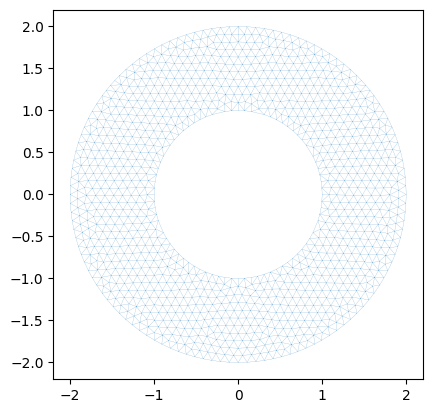

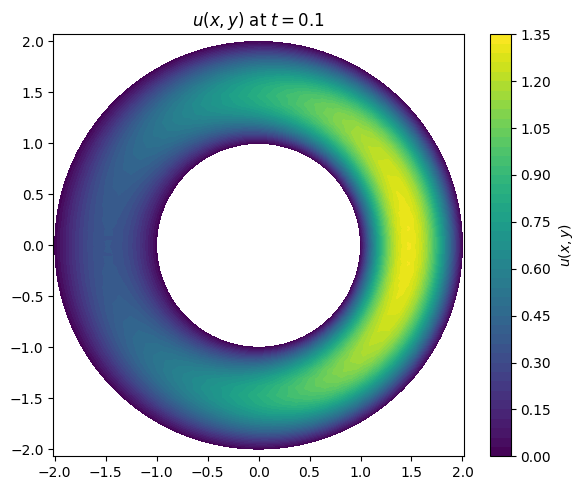

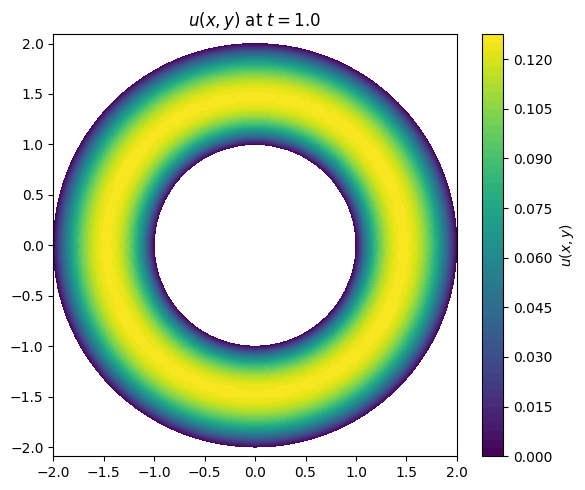

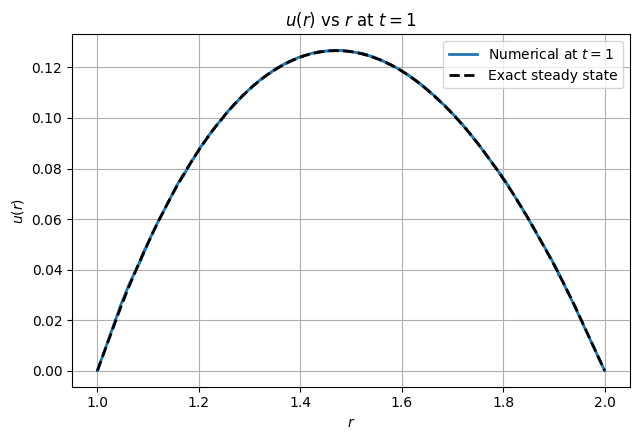

In [19]:
#Problem 3b

fd = lambda p: ddiff(dcircle(p, 0, 0, 2), dcircle(p, 0, 0, 1))
fh = huniform
bbox = [-2, 2, -2, 2]
pfix = np.vstack([
    np.array([[np.cos(th), np.sin(th)]]) * r
    for r in [1, 2] for th in np.linspace(0, 2*np.pi, 40, endpoint=False)
])
p, tri = distmesh2D(fd, fh, 0.1, bbox, pfix)

Npts = p.shape[0]
M = lil_matrix((Npts, Npts))
K = lil_matrix((Npts, Npts))
F = np.zeros(Npts)

for t in tri:
    x = p[t, 0]
    y = p[t, 1]
    area = 0.5 * np.linalg.det(np.array([
        [1, x[0], y[0]],
        [1, x[1], y[1]],
        [1, x[2], y[2]]
    ]))
    C = np.array([[1, x[0], y[0]],
                  [1, x[1], y[1]],
                  [1, x[2], y[2]]])
    grad = np.linalg.inv(C)[1:, :]
    for i in range(3):
        for j in range(3):
            M[t[i], t[j]] += area * (1 + (i == j)) / 12 if i != j else area / 6
            K[t[i], t[j]] += area * grad[:, i] @ grad[:, j]
        F[t[i]] += area / 3

M = csr_matrix(M)
K = csr_matrix(K)

x, y = p[:, 0], p[:, 1]
r_vals = np.sqrt(x**2 + y**2)
phi_vals = np.arctan2(y, x)
U0 = r_vals + np.cos(phi_vals)

tol = 1e-3
boundary_nodes = np.where((np.abs(r_vals - 1) < tol) | (np.abs(r_vals - 2) < tol))[0]
interior = np.setdiff1d(np.arange(Npts), boundary_nodes)

dt = 0.01
Nt = int(1.0 / dt)
Us = [U0.copy()]
A = M + 0.5 * dt * K
B = M - 0.5 * dt * K
rhs_force = dt * F

for n in range(Nt):
    Un = Us[-1]
    rhs = B @ Un + rhs_force
    Unp1 = Un.copy()
    Unp1[interior] = spsolve(A[interior][:, interior], rhs[interior])
    Unp1[boundary_nodes] = 0
    Us.append(Unp1)

from matplotlib.tri import Triangulation

triang = Triangulation(p[:, 0], p[:, 1], tri)
for t_val in [0.1, 1.0]:
    idx = int(t_val / dt)
    plt.figure(figsize=(6, 5))
    plt.tricontourf(triang, Us[idx], levels=50, cmap='viridis')
    plt.colorbar(label='$u(x, y)$')
    plt.title(f'$u(x,y)$ at $t = {t_val}$')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

u_final = Us[-1]
r = np.sqrt(p[:, 0]**2 + p[:, 1]**2)
r_sort = np.argsort(r)
r_sorted = r[r_sort]
u_sorted = u_final[r_sort]

def u_exact(r):
    return (1 - r**2)/4 + (3 * np.log(r)) / (4 * np.log(2))

plt.figure(figsize=(6.5, 4.5))
plt.plot(r_sorted, u_sorted, label='Numerical at $t=1$', linewidth=2)
plt.plot(r_sorted, u_exact(r_sorted), 'k--', label='Exact steady state', linewidth=2)
plt.xlabel('$r$')
plt.ylabel('$u(r)$')
plt.title('$u(r)$ vs $r$ at $t = 1$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
